In [1]:
import rebound
import reboundx
import sys
sys.path.append('../systemsounds')
import systemsounds as ss
import numpy as np
from random import random, uniform, seed
from systemsounds import EventRecorder
import pandas as pd
import os

In [6]:
def acrit(sim): # Holman & Wiegert 99 for P type circumbinary
    ps = sim.particles
    mu = ps[1].m/(ps[1].m+ps[0].m)
    return 1.60 + 5.10*ps[1].e -2.22*ps[1].e**2 + 4.12*mu -4.27*ps[1].e*mu -5.09*mu**2 + 4.61*ps[1].e**2*mu**2 

def stop(reb_sim, reb_col):
    reb_sim.contents._status = 6
    return 0

def distance(sim, i1, i2):
    ps = sim.particles
    diff = ps[i2]-ps[i1]
    return np.sqrt(diff.x**2 + diff.y**2 + diff.z**2)

class mindRecorder(EventRecorder):
    def __init__(self, sim, starindex):
        self.starindex = starindex
        self.mind = 0.99*min(distance(sim, 0, 2), distance(sim, 1,2)) # needs to start less than initial value
        self.mind0 = self.mind
        super(mindRecorder, self).__init__(sim, lambda sim, i: self.mind-distance(sim, 2, self.starindex), targets=[None])
    def process_event(self, event_sim, target=None):
        self.mind = distance(event_sim, 2, self.starindex)
        super(mindRecorder, self).process_event(event_sim, target)

In [7]:
def runbinary(randseed=0, mratio=None, ebinary=None):
    seed(randseed)
    if mratio is None:
        mratio = random()
    if ebinary is None:
        ebinary = 0.9*random()
        
    sim = rebound.Simulation()
    sim.G = 4*np.pi**2
    Rmin = 1.e-2
    sim.add(m=1., r=Rmin)
    sim.add(m=mratio, a=1., e=ebinary, r=Rmin, pomega=random()*2.*np.pi, f=random()*2.*np.pi)
    sim.move_to_com()
    ps = sim.particles
    sim.add(a=1.2*acrit(sim), f=random()*2.*np.pi)
    
    sim.exit_max_distance= 100.
    sim.collision="direct"
    sim.collision_resolve = stop

    rebx = reboundx.Extras(sim)
    rebx.add("modify_orbits_forces")
    ps[2].params['tau_a'] = -1000*ps[2].P
    
    recorder1 = mindRecorder(sim, 0)
    recorder2 = mindRecorder(sim, 1)
    tmax=1.e4
    
    code=0
    try:
        sim.integrate(tmax)
    except KeyboardInterrupt:
        code=1
    except rebound.Escape:
        code=2
    
    with open('Nbody.txt', 'a') as f:
        f.write('{0}\t{1}\t{2}\t{3}\t{4}\t{5}\t{6}\n'.format(randseed, recorder1.mind, recorder2.mind, recorder1.mind0, mratio, ebinary, code))

In [8]:
for i in range(1611, 2000):
    runbinary(i)

In [54]:
def get_a_binary(M_primary):
    return 1.

def get_a_Roche(Mstar):
    rho_sun = 1.4
    rho_body = 3
    Rsun = 5e-3
    return 1.26*Mstar**(1./3.)*(rho_sun/rho_body)**(1./3.)*Rsun

def get_Rstar(Mstar):
    Rsun = 5.e-3
    return 10**PolyRfuncM(np.log10(Mstar))*Rsun

get_a_binary = np.vectorize(get_a_binary)
get_a_Roche = np.vectorize(get_a_Roche)
get_Rstar = np.vectorize(get_Rstar)

In [85]:
typemasses = {'VLM':[1.e-3, 0.1], 'M':[0.1, 0.6], 'FGK':[0.6, 1.4], 'A':[1.4, 6.5], 'OB':[6.5, 100]}

def get_type(M):
    for key, value in typemasses.items():
        if M > value[0] and M < value[1]:
            return key
    return np.nan

def sample_mass(startype):
    Mmin, Mmax = typemasses[startype]
    return Mmin + (Mmax-Mmin)*random()

In [ ]:
if M <= 0.1:
   s_type = ('VLM')
   a_avg = 4.5#average separation (au)
   a_sigma = 0.333
elif M > 0.1 and M <= 0.6:
   s_type = ('Mstar')
   a_avg = 5.3#average separation (au)
   a_sigma = 0.867
elif M > 0.6 and M <= 1.4:
   s_type = ('FKG')
   a_avg = 45#average separation (au)
   a_sigma = 1.533
elif M > 1.4 and M <= 6.5:
   s_type = ('A stars')
   bimodal = 1
   a_avg = 350
   a_avg2 = 0.2
   a_sigma = 1.533
   a_sigma2 = 1
elif M > 6.5 and M <= 16:
   s_type = ('EarlyB')
   powerlaw = 1
   a_avg = 0.2
   a_sigma = 1.533
elif M > 16:
   s_type = ('Ostar')
   powerlaw = 1
   a_avg = 0.2
   a_sigma = 0.1677

In [60]:
def sample(randseed=0):
    seed(randseed)
    Mmin = 0.1
    Mmax = 0.5
    M = Mmin + (Mmax-Mmin)*random()
    a_bin = get_a_binary(M)
    a_Roche1 = get_a_Roche(M)
    a_Roche2 = get_a_Roche(M*q)
    Rstar1 = get_Rstar(M)
    Rstar2 = get_Rstar(M*q)

    row = a[np.random.randint(0, a.shape[0])]
    dmin1 = row[0]
    dmin2 = row[1]
    q = row[3]

    dmin1Roche = dmin1*a_bin/a_Roche1
    dmin2Roche = dmin2*a_bin/a_Roche2
    dmin1R = dmin1*a_bin/Rstar1
    dmin2R = dmin2*a_bin/Rstar2

0.39349795593439396

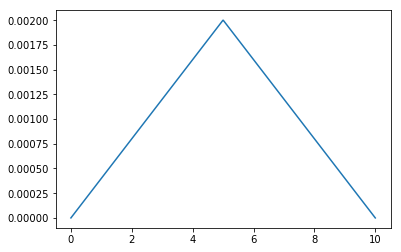

In [92]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
def test(M):
    if M < 5:
        return M/2497.4974974974975
    if M >= 5:
        return (10-M)/2497.4974974974975
test = np.vectorize(test)
m = np.linspace(0,10,1000)
pdf = [test(M) for M in m]
plt.plot(m, pdf)
plt.show()

In [20]:
np.array(pdf).sum()

1.0

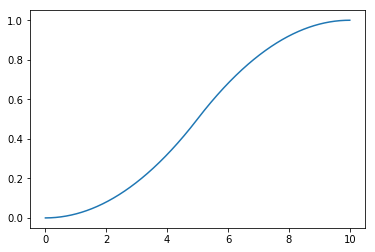

In [21]:
cdf = np.cumsum(pdf)
plt.plot(m, cdf)
plt.show()

In [22]:
from scipy.interpolate import interp1d
f = interp1d(cdf, m)

In [23]:
f(0.5)

array(4.994994994995002)

1.0


(array([  16.,   28.,   55.,   67.,   89.,  124.,  152.,  141.,  172.,
         174.,  209.,  263.,  247.,  283.,  306.,  301.,  323.,  374.,
         407.,  356.,  438.,  431.,  449.,  468.,  487.,  500.,  545.,
         581.,  587.,  579.,  594.,  653.,  649.,  650.,  678.,  671.,
         735.,  753.,  792.,  761.,  775.,  814.,  848.,  882.,  816.,
         952.,  908.,  981.,  999.,  999.,  973.,  968.,  968.,  878.,
         911.,  933.,  892.,  834.,  833.,  809.,  717.,  824.,  702.,
         730.,  723.,  680.,  698.,  599.,  658.,  633.,  593.,  591.,
         536.,  536.,  478.,  506.,  455.,  463.,  418.,  436.,  403.,
         377.,  360.,  327.,  281.,  279.,  260.,  249.,  223.,  210.,
         188.,  171.,  158.,  129.,  100.,   79.,   73.,   55.,   27.,   14.]),
 array([ 0.02335577,  0.12292168,  0.22248758,  0.32205349,  0.4216194 ,
         0.5211853 ,  0.62075121,  0.72031712,  0.81988302,  0.91944893,
         1.01901484,  1.11858075,  1.21814665,  1.31771256,  1.4

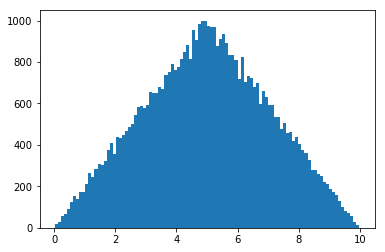

In [93]:
f = sampler(m, test)
plt.hist(f(np.random.random([50000])), bins=100)

(array([   14.,    20.,    52.,    74.,    93.,   114.,   142.,   166.,
          173.,   193.,   237.,   230.,   251.,   258.,   310.,   313.,
          324.,   341.,   377.,   400.,   378.,   416.,   466.,   467.,
          516.,   493.,   539.,   556.,   572.,   625.,   589.,   623.,
          631.,   629.,   647.,   722.,   693.,   740.,   727.,   816.,
          804.,   852.,   869.,   830.,   848.,   939.,   918.,   938.,
          908.,   996.,  1030.,   988.,   930.,   957.,   896.,   886.,
          842.,   858.,   833.,   758.,   792.,   793.,   754.,   741.,
          710.,   695.,   655.,   673.,   648.,   569.,   609.,   559.,
          552.,   506.,   459.,   473.,   508.,   500.,   417.,   412.,
          389.,   373.,   364.,   356.,   340.,   312.,   258.,   242.,
          229.,   232.,   197.,   177.,   167.,   128.,   118.,   101.,
           76.,    58.,    34.,    17.]),
 array([  1.25692783e-03,   1.00826850e-01,   2.00396773e-01,
          2.99966696e-01,   3.99

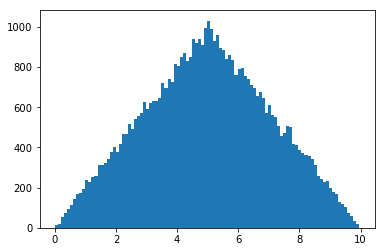

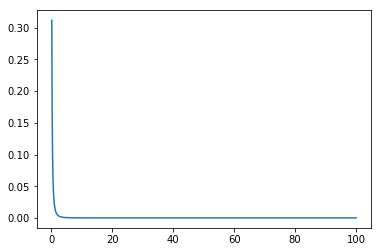

In [106]:
%matplotlib inline
import matplotlib.pyplot as plt
def IMFChab(M):
    IMFChab = 0.086*(1./(np.log(10)*M))*np.exp(-((np.log10(M)-np.log10(0.22))**(2.))/(2.*0.57**2.))
    return IMFChab

starmasses = np.linspace(0.1,100,100000)
IMF = IMFChab(starmasses)
plt.plot(starmasses, IMF)
#plt.xscale('log')
plt.show()

In [ ]:
log10M = lnM/ln10

In [ ]:
df/dlog10M = ln10*M df/dM

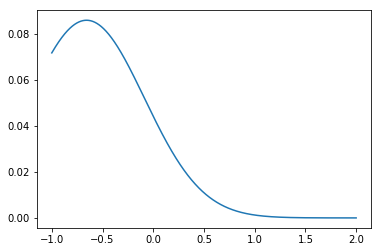

In [99]:
%matplotlib inline
import matplotlib.pyplot as plt
def logIMFChab(logM):
    IMFChab = 0.086*np.exp(-((logM-np.log10(0.22))**(2.))/(2.*0.57**2.))
    return IMFChab

starmasses = np.linspace(-1, 2, 100000)
IMF = logIMFChab(starmasses)
plt.plot(starmasses, IMF)
#plt.xscale('log')
plt.show()

1.0


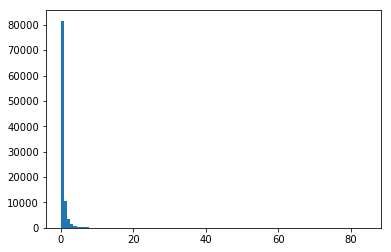

In [105]:
f = sampler(starmasses, logIMFChab)
ret = plt.hist(10**f(np.random.random([100000])), bins=100)

In [28]:
IMF.sum()

1.0000000000000004

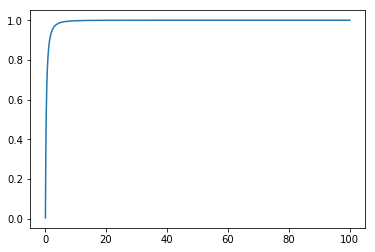

In [29]:
IMFcdf = np.cumsum(IMF)
plt.plot(starmasses, IMFcdf)
#plt.xscale('log')
plt.show()

In [67]:
from scipy.interpolate import interp1d
f = interp1d(IMFcdf, starmasses)

In [70]:
IMFcdf.min()

0.0034860419870479365

In [87]:
def sampler(values, pdffunc):
    pdf = pdffunc(values)
    pdf/=pdf.sum()
    cdf = np.cumsum(pdf)
    f = interp1d(cdf, values)
    def wrapper(cdfval):
        try:
            return f(cdfval)
        except ValueError:
            if cdfval < cdf.min():
                return values.min()
            elif cdfval > cdf.max():
                return values.max()
    wrapper = np.vectorize(wrapper)
    return wrapper

1.0


(array([ 17.,  18.,  27.,  19.,  29.,  21.,  20.,  24.,  18.,  17.,  24.,
         26.,  19.,  24.,  20.,  28.,  27.,  20.,  18.,  24.,  17.,  26.,
         22.,  19.,  21.,  19.,  20.,  13.,  25.,  17.,  18.,  14.,  25.,
         13.,  24.,  11.,  20.,  11.,   9.,  13.,  14.,   8.,  14.,   7.,
         14.,  11.,   3.,  15.,  10.,  10.,   6.,   7.,   9.,   3.,   3.,
          5.,   5.,   3.,  10.,   4.,   6.,   2.,   3.,   3.,   3.,   3.,
          3.,   1.,   2.,   3.,   1.,   1.,   2.,   2.,   0.,   1.,   1.,
          0.,   1.,   0.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          1.]), array([ -1.00000000e+00,  -9.76198196e-01,  -9.52396392e-01,
         -9.28594589e-01,  -9.04792785e-01,  -8.80990981e-01,
         -8.57189177e-01,  -8.33387373e-01,  -8.09585569e-01,
         -7.85783766e-01,  -7.61981962e-01,  -7.38180158e-01,
         -7.14378354e-01,  -6.90576550e-01,  -6.66774747e-01,
         

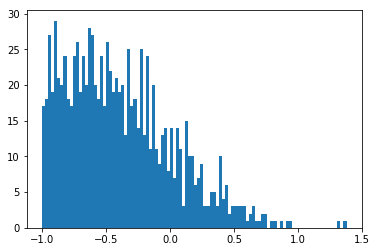

In [94]:
f = sampler(starmasses, IMFChab)
plt.hist(np.log10(f(np.random.random([1000]))), bins=100)

In [88]:
f = sampler(starmasses, IMFChab)

1.0


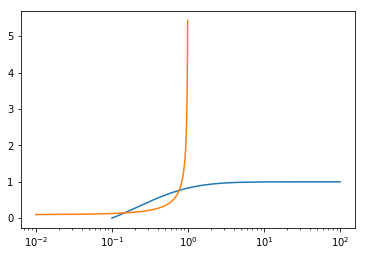

In [41]:
plt.plot(starmasses, IMFcdf)
plt.plot(np.linspace(0.01,0.99,1000), f(np.linspace(0.01,0.99,1000)))
plt.xscale('log')
plt.show()

In [33]:
IMFcdf

array([ 0.00348604,  0.00695324,  0.01040169, ...,  1.        ,
        1.        ,  1.        ])

In [209]:
sample_from_IMF(2)

0.9560342718892494 0.2404


2.5016200162001621

In [205]:
starmasses[977]

1.0760327603276034

In [12]:
def find_nearest(array,value):
    return np.abs(array-value).argmin()

def sample_from_IMF(randseed=0):
    seed(randseed)
    val = random()
    idx = find_nearest(IMFcdf, val)
    #print(val, idx/10000)
    return starmasses[idx]

In [13]:
b = [np.log10(sample_from_IMF(i)) for i in range(10000)]

(array([  2.50200000e+03,   2.47000000e+03,   2.18300000e+03,
          1.46300000e+03,   8.41000000e+02,   3.58000000e+02,
          1.26000000e+02,   4.50000000e+01,   1.10000000e+01,
          1.00000000e+00]),
 array([-1.        , -0.73487539, -0.46975078, -0.20462618,  0.06049843,
         0.32562304,  0.59074765,  0.85587226,  1.12099686,  1.38612147,
         1.65124608]),
 <a list of 10 Patch objects>)

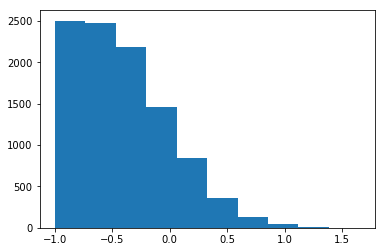

In [14]:
plt.hist(b)

In [227]:
np.random.random([2])

array([ 0.4170149 ,  0.58703222])

In [235]:
np.random.random([100]).max()

0.99370252715694896

In [46]:
plt.hist(f(np.random.random([500])))

ValueError: A value in x_new is below the interpolation range.

In [56]:
cdf.min()

0.0

In [57]:
cdf.max()

0.99999999999999878

In [82]:
t = np.random.random([1000])

(array([ 22.,  25.,  18.,  23.,  27.,  19.,  23.,  15.,  19.,  20.,  32.,
         16.,  14.,  32.,  24.,  19.,  13.,  18.,  18.,  21.,  20.,  24.,
         17.,  16.,  16.,  14.,  18.,  14.,  22.,  18.,  19.,  21.,  13.,
         16.,  18.,  18.,  20.,  14.,  21.,  16.,  18.,  12.,  13.,   5.,
          8.,   7.,  12.,  10.,   9.,   8.,  15.,   7.,   8.,   5.,   2.,
          5.,   4.,   4.,   7.,   4.,   3.,   3.,  12.,   2.,   1.,   3.,
          3.,   6.,   5.,   2.,   0.,   1.,   2.,   1.,   2.,   2.,   1.,
          2.,   2.,   1.,   5.,   2.,   0.,   0.,   0.,   0.,   2.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([-1.        , -0.97738955, -0.95477911, -0.93216866, -0.90955821,
        -0.88694777, -0.86433732, -0.84172687, -0.81911643, -0.79650598,
        -0.77389553, -0.75128509, -0.72867464, -0.70606419, -0.68345375,
        -0.6608433 , -0.63823285, -0.61562241, -0.59301196, -0.57040151,
        -0.54779107, -0.52

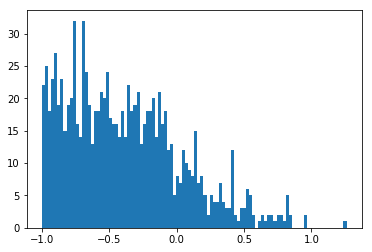

In [85]:
plt.hist(np.log10(f(t)), bins=100)

In [113]:
find_nearest(mIMFcdf, 0.5)

118

In [114]:
starmasses[118]

1.2789378937893792

In [109]:
mIMFcdf[119]

0.5025035315571611

In [102]:
IMFChab(arraytest).sum()

0.99999999999999978

In [75]:
a[np.random.randint(0, 100)]

array([ 2.45637413,  1.11293799,  4.78878971,  0.10682854,  0.63232697,  2.        ])

In [61]:
a.T[0]

array([ 1.78329977,  1.52557641,  1.87137137,  1.61715802,  1.51593435,
        1.55447933,  2.0318769 ,  1.49197215,  1.47389207,  1.86556759,
        1.78329977,  1.52557641,  1.87137137,  1.61715802,  1.51593435,
        1.55447933,  2.0318769 ,  1.49197215,  1.47389207,  1.86556759,
        1.5571218 ,  1.73793254,  1.58650227,  1.7635907 ,  2.45637413,
        0.86173634,  1.67033211,  1.76815646,  2.15946278,  1.65666711,
        1.98389217,  1.80264726,  1.19839629,  1.53667233,  1.71625098,
        1.78736884,  1.57184552,  1.37976748,  0.95539387,  1.54733047,
        2.0864506 ,  1.02912888,  1.65990233,  1.90729919,  1.90540263,
        1.61849337,  1.88943365,  1.33621662,  1.5688969 ,  2.2054188 ,
        1.78329977,  1.52557641,  2.88160079,  1.61715802,  1.51593435,
        1.55447933,  2.0318769 ,  1.49197215,  1.47389207,  1.86556759,
        1.5571218 ,  1.73793254,  1.58650227,  1.7635907 ,  2.45637413,
        0.86173634,  1.67033211,  1.76815646,  2.15946278,  1.65

In [52]:
get_a_binary(a.T[0])

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [21]:
%%time
runbinary(randseed=2)

CPU times: user 1min 7s, sys: 73.7 ms, total: 1min 7s
Wall time: 1min 7s


(2.3188690829069274,
 1.6683421439663941,
 5.0379786134527178,
 0.9560342718892494,
 0.9478274870593494,
 2)

In [118]:
sim = rebound.Simulation()
sim.G = 4*np.pi**2
Rmin = 1./215.
sim.add(m=1., r=Rmin)
sim.add(m=1., a=1., e=0.1, r=Rmin)
sim.move_to_com()
ps = sim.particles

In [119]:
print('acrit = {0}'.format(acrit(sim)))
sim.add(a=1.2*acrit(sim))
print(ps[2].a)
sim.exit_max_distance= 100.
sim.collision="direct"
sim.collision_resolve = stop

rebx = reboundx.Extras(sim)
rebx.add("modify_orbits_forces")
ps[2].params['tau_a'] = -1000*ps[2].P

acrit = 2.6733249999999997
3.2079899999999997


In [3]:
recorder1 = mindRecorder(sim, 0)
recorder2 = mindRecorder(sim, 1)

NameError: name 'sim' is not defined

In [121]:
%%time
Nout = 1000
tmax = 10000
times = np.linspace(0, tmax, Nout)
d1, d2 = np.zeros(Nout), np.zeros(Nout)
P, e = np.zeros(Nout), np.zeros(Nout)

try:
    for i, time in enumerate(times):
        sim.integrate(time)
        d1[i] = distance(2, 0)
        d2[i] = distance(2, 1)
        P[i] = ps[2].P
        e[i] = ps[2].e
except KeyboardInterrupt:
    print("collision")
except rebound.Escape:
    print("escape")

escape
CPU times: user 5.37 s, sys: 24.9 ms, total: 5.39 s
Wall time: 5.42 s


In [122]:
recorder2.mind

1.2265316858253774

In [123]:
recorder1.mind

1.3890708302316288

In [19]:
sim.t

0.2696133632101861

(0, 3)

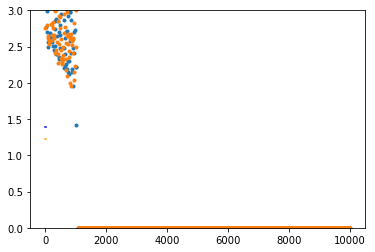

In [124]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax= plt.subplots()
ax.plot(times, d1, '.')
ax.plot([0,10], [recorder1.mind, recorder1.mind], 'blue')
ax.plot(times, d2, '.')
ax.plot([0,10], [recorder2.mind, recorder2.mind], 'orange')


#ax.set_xlim([0,10])
ax.set_ylim([0,3])

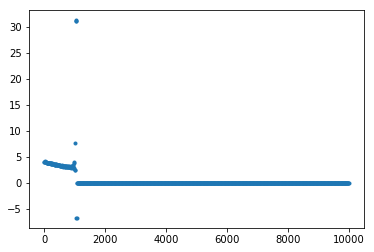

In [125]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax= plt.subplots()
ax.plot(times, P, '.')

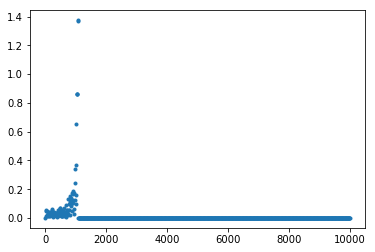

In [126]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax= plt.subplots()
ax.plot(times, e, '.')

In [5]:
runbinary(1)

3.2079899999999975
1053.657472316494 1.47545167801 1.19094200001


(1.4754516780140603, 1.1909420000054411)